In [1]:
import os
from os import listdir
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
import string
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import math
from collections import Counter
import numpy as np
import statistics
import operator
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from num2words import num2words
import matplotlib.pyplot as plt

In [2]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles


path="20_newsgroups"
folder_path=getListOfFiles(path)
#print((folder_path))
#print("done")


for i in range (0,5000,1000):
    print(folder_path[i])
print(len(folder_path))

20_newsgroups/sci.med/59199
20_newsgroups/comp.graphics/38703
20_newsgroups/rec.sport.hockey/53700
20_newsgroups/talk.politics.misc/178450
20_newsgroups/sci.space/60196
5000


In [3]:
def convert_tolowercase(data):
    return (data.lower())


def regextokenizer_func(data):
    #print(type(data))
    tokenizer=RegexpTokenizer(r'\w+')
    data=tokenizer.tokenize(data)
    return data

def remove_stopwords(data):
    stop_words=set(stopwords.words('english'))
    result=[i for i in data if not i in stop_words]
    return result


def lemmatization_func(data):
    lemmatizer=WordNetLemmatizer()
    result=[]
    for word in data:
        result.append(lemmatizer.lemmatize(word))
    return result

def stemming_func(data):
    stemmer=PorterStemmer()
    tokenizer=RegexpTokenizer(r'\w+')
    tokens=tokenizer.tokenize(data)
    data_new=""
    for i in tokens:
        data_new+=" "+stemmer.stem(i)
    return data_new
def convert_numbers(k):
    for i in range(len(k)):
        try:
            k[i] = num2words(int(k[i]))
        except:
            pass
    return k

In [4]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c


def cosine_dot(a,b):
    if (np.linalg.norm(a)==0 or np.linalg.norm(b)==0):
        return 0;
    else:
        temp=np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
        return temp




In [5]:
total_doc_id=[]
body_list=[]
doc=0
print(folder_path[0])
doc_ids=[]
for i in range (0,len(folder_path),1):
    text=open(folder_path[i],encoding='utf-8',errors='ignore').read().strip()
    text=convert_tolowercase(text)
    text=stemming_func(text)
    text=regextokenizer_func(text)
    text=lemmatization_func(text)
    text=remove_stopwords(text)
    body_list.append(text)
    indx=folder_path[i].rfind('/')
    doc_ids.append(folder_path[i][indx+1:len(folder_path[i])])
    
print(len(body_list))
#print(doc_ids)


20_newsgroups/sci.med/59199
5000


In [6]:
DF={}
cnt=0
for tokens in body_list:
    for word in tokens:
        try:
            DF[word].add(cnt)
        except:
            DF[word]={cnt}
    cnt+=1
for i in DF:
    DF[i]=len(DF[i])
print(len(DF))

56729


In [7]:
N=len(body_list)
tf_idf={}
doc=0
for tokens in body_list:
    counter=Counter(tokens)
    word_len=len(counter)
    for word in (tokens):
        tf=counter[word]/word_len
        df=doc_freq(word)
        idf=np.log(N+1)/df+1
        tf_idf[doc,word]=tf*idf
    doc+=1


In [8]:
total_vocab_size = len(DF)
total_vocab = [x for x in DF]
D = np.zeros((N, total_vocab_size))
for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        D[i[0]][ind] = tf_idf[i]
    except:
        pass

D.shape

(5000, 56729)

In [9]:
def query_matrix_func(query):
    mat=np.zeros((len(total_vocab)),dtype='float16')
    counter1=Counter(query)
    word_len1=len(counter1)
    query_tf_idf={}
    for word in np.unique(query):
        tf=counter1[word]/word_len1
        df=doc_freq(word)
        idf=np.log(N+1)/(df+1)
        try:
            ind=total_vocab.index(word)
            mat[ind]=tf*idf
        except:
            pass
    return mat

In [10]:
def cosine_similarity_func(query_mat,k):
    cos_sim=[]
    for d in D:
        cos_sim.append(cosine_dot(query_mat,d))
    outpt=np.array(cos_sim).argsort()[-k:][::-1]
    #print(cos_sim)
    return list(outpt)
        

In [49]:
#function of getting feedback and marking relevant
def get_feedback_func(retrieved_docs):
    #inp_feed=(input("Enter the relevant docs no").split(" "))
    D_rel=[]
    D_non_rel=[]
    #D_rel=[int(i) for i in inp_feed]
    p=0.1*k
    for i in range (0,len(retrieved_docs),1):
        if(base_folder=='sci.med'):
            if (retrieved_docs[i]>=0 and retrieved_docs[i]<=999):
                 D_rel.append(retrieved_docs[i])
        if(base_folder=='comp.graphics'):
            if (retrieved_docs[i]>=1000 and retrieved_docs[i]<=1999):
                D_rel.append(retrieved_docs[i])
        if(base_folder=='rec.sport.hockey'):
            if (retrieved_docs[i]>=2000 and retrieved_docs[i]<=2999):
                D_rel.append(retrieved_docs[i])
        if(base_folder=='talk.politics.misc'):
            if (retrieved_docs[i]>=3000 and retrieved_docs[i]<=3999):
                D_rel.append(retrieved_docs[i])
        else:    
            if (retrieved_docs[i]>=4000 and retrieved_docs[i]<=4999):
                D_rel.append(retrieved_docs[i])
        if (len(D_rel)>=p):
            break
    
    D_non_rel=list(set(retrieved_docs)-set(D_rel))
    return D_rel,D_non_rel

In [44]:
#PR plot function
map_iteration_list=[]
def PR_MAP_plot(retrieved_docs,base_folder):
    relevant=0;
    total=1000;
    precision_list=[]
    recall_list=[]
    precision_map_list=[]
    for i in range (0,len(retrieved_docs),1):
        if(base_folder=='sci.med'):
            if (retrieved_docs[i]>=0 and retrieved_docs[i]<=999):
                relevant+=1
                precision_map_list.append(relevant/(i+1))
                
        if(base_folder=='comp.graphics'):
            if (retrieved_docs[i]>=1000 and retrieved_docs[i]<=1999):
                relevant+=1
                precision_map_list.append(relevant/(i+1))
        if(base_folder=='rec.sport.hockey'):
            if (retrieved_docs[i]>=2000 and retrieved_docs[i]<=2999):
                relevant+=1
                precision_map_list.append(relevant/(i+1))
        if(base_folder=='talk.politics.misc'):
            if (retrieved_docs[i]>=3000 and retrieved_docs[i]<=3999):
                relevant+=1
                precision_map_list.append(relevant/(i+1))
        else:    
            if (retrieved_docs[i]>=4000 and retrieved_docs[i]<=4999):
                relevant+=1
                precision_map_list.append(relevant/(i+1))
            
        recall_list.append(relevant/1000)
        precision_list.append(relevant/(i+1))
    
    plt.plot(recall_list,precision_list)
    plt.title("Precision and recall curve")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.show()
    temp_map=sum(precision_map_list)/len(precision_map_list)
    print("MAP is :- ",temp_map)
    map_iteration_list.append(temp_map)
    precision_list.clear()
    recall_list.clear()  
    precision_map_list.clear()

In [45]:
def calc_centroid_func(docs_id):
    vect=[D[i] for i in docs_id]
    return np.array(vect).sum(axis=0)/len(docs_id)

In [66]:
#TSNE plot function
def gen_tsne(Q_r, Q_nr, Q_m):
    tsne = TSNE(n_components=2, random_state=0)

    feature_vector = []
    labels = []

    for i in Q_r:
        feature_vector.append(D[i])
        labels.append(0)
    for i in Q_nr:
        feature_vector.append(D[i])
        labels.append(1)

    feature_vector.append(Q_m)
    labels.append(2)
    print(Q_m)
    transformed_data = tsne.fit_transform(np.array(feature_vector))
    k = np.array(transformed_data)
    t = ("Relevant", "Non Relevant", "Query")
    plt.scatter(k[:, 0], k[:, 1], c=labels, s=60, alpha=0.8, label="Violet-R, Aqua-NR")
    plt.title("Rocchio Algorithm")
    plt.legend()
    plt.grid(True)
    plt.show()

In [67]:
#Rocchio algorithm function
def query_feedback_func(alpha,beta,gamma,k,query,times,orig_query,base_folder):
    query_mat=query_matrix_func(query)
    for i in range(times):
        print("\n Iteration ",i)
        
        if hash(orig_query) in history_query:
            tempo=history_query[hash(orig_query)]
            Q_M=tempo[0]
            Q_R=tempo[1]
            Q_NR=tempo[2]
            Q_M=(alpha*Q_M)+(beta*calc_centroid_func(Q_R)-(gamma*calc_centroid_func(Q_NR)))
        else:
            Q_M=query_mat
            Q_R=set()
            Q_NR=set()
        
        retrieved_docs=cosine_similarity_func(Q_M,k)
#         len_temp=len(retrieved_docs)
#         display_docs=[None]*len_temp
#         for j in range(0,len_temp,1):
#             display_docs[j]=(doc_ids[retrieved_docs[j]])
#         print("Retrievd docs are ",display_docs)
        
        print("Retrieved docs are :-",retrieved_docs)
        PR_MAP_plot(retrieved_docs,base_folder)
        
        if(i==times):
            break
        temp=get_feedback_func(retrieved_docs)

        
        Q_R= Q_R|set(temp[0])
        Q_NR=Q_NR|set(temp[1])
        
    
        print("Releavnt docs are :- ",Q_R)
        print("Non Relevant docs are :-",Q_NR)
        gen_tsne(Q_R,Q_NR,Q_M)
    
        history_query[hash(orig_query)]=[Q_M,Q_R,Q_NR]
        

In [68]:
#query=" Scientific tools for preserving rights and body"
query="Pretty good opinions on biochemistry machines"
#query="Frequently asked questions on State-of-the-art visualisation tools"
k=100;
#query=input("Enter phrasal query")
#k=input("enter k")
orig_query=query
query=convert_tolowercase(query)
query=regextokenizer_func(query)
query=lemmatization_func(query)
query=remove_stopwords(query)
print((query))
query_len=len(query)
print(query_len)
print(orig_query)

['pretty', 'good', 'opinion', 'biochemistry', 'machine']
5
Pretty good opinions on biochemistry machines



 Iteration  0
[0. 0. 0. ... 0. 0. 0.]


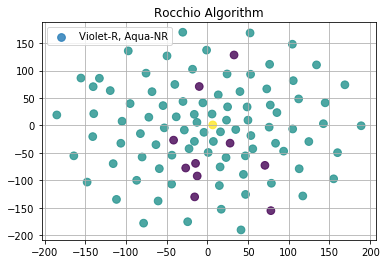


 Iteration  1
[0.00176785 0.00202101 0.00180665 ... 0.         0.         0.        ]


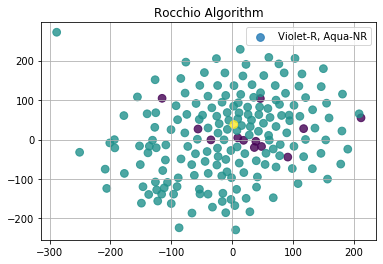


 Iteration  2
[0.0033088  0.00375283 0.00315175 ... 0.         0.         0.        ]


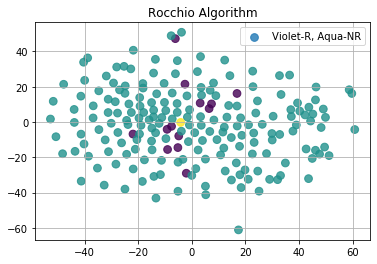


 Iteration  3
[0.00481318 0.00542708 0.00463024 ... 0.         0.         0.        ]


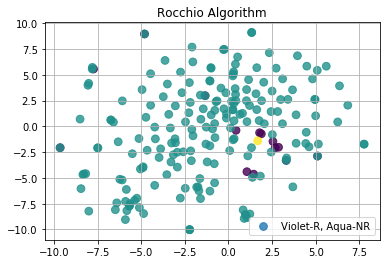

In [69]:
map_iteration_list.clear()
alpha=1 
beta=0.7
gamma=0.25 
times=4
base_folder='sci.med'
#base_folder='talk.politics.misc'
history_query={} 
query_feedback_func(alpha,beta,gamma,k,query,times,orig_query,base_folder)
iteration_list=[]

for i in range(times):
    iteration_list.append(i+1)
#print(iteration_list)
#print(map_iteration_list)
# plt.plot(iteration_list,map_iteration_list)
# plt.title("plot of MAP vs iteration")
# plt.xlabel("Iterartions")
# plt.ylabel("MAP")
# plt.show()
